# Imports

In [88]:
using CSV
using DataFrames
using Statistics
using Dates
using Random
using Plots
using StatsBase
using GLM
using StatsPlots
using PairPlots
using CairoMakie


# Cleaning the data

## Eliminating double comas ",," after wrong column
Changing them to ","

In [89]:
# Preparar paths
path = "dataSets/damCombustible.csv"
cleaned_path = "dataSets/damCombustible_cleaned.csv"

# Corregir cada linea del CSV
function fix_csv_line(line::String)
    parts = split(line, ",")
    horometro_index = 3
    
    if length(parts) > horometro_index + 1 && !isempty(parts[horometro_index + 1])
        while length(parts) > horometro_index + 2 && parts[horometro_index + 2] == ""
            parts = vcat(parts[1:horometro_index + 1], parts[horometro_index + 3:end])
        end
    end

    return join(parts, ",")
end
        

function correct_csv_file(input_path::String, output_path::String)
    csv_lines = readlines(input_path)

    fixed_lines = [fix_csv_line(line) for line in csv_lines]

    open(output_path, "w") do file
        for line in fixed_lines
            println(file, line)
        end
    end
end

correct_csv_file(path, cleaned_path)

df = CSV.read(cleaned_path, DataFrame)
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Nro.,320.709,2,322.5,638,0,Int64
2,Vehículo,105.566,101,105.0,110,0,Int64
3,Odómetro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Horómetro,40.0,4,33.0,86,618,"Union{Missing, Int64}"
5,Fecha,,01/abr./2024 12:39:00,,31/may./2024 1:54:00,0,String31
6,Tanqueo Full,,N,,S,0,String1
7,Costo por Volumen,,"23,24",,"26,97",0,String7
8,Cant.,,100,,"99,13",0,String7
9,Unidad,,Litros,,Litros,0,String7


## Changing columns data-type to correct data-type
Fecha = DateTime

Tanqueo Full = Bool

Costo por Volumen = Float32

Cantidad = Float32

Costo Total = Float32

In [90]:
propertynames(df)

12-element Vector{Symbol}:
 Symbol("Nro.")
 :Vehículo
 :Odómetro
 :Horómetro
 :Fecha
 Symbol("Tanqueo Full")
 Symbol("Costo por Volumen")
 Symbol("Cant.")
 :Unidad
 Symbol("Costo Total")
 :Tipo
 :Column12

In [91]:
# Rename columns
rename!(df, Symbol("Nro.") => :Numero,
    :Vehículo => :Vehiculo, :Odómetro => :Odometro,
    :Horómetro => :Horometro,
    Symbol("Tanqueo Full") => :Tanque_Lleno,
    Symbol("Costo por Volumen") => :Costo_Por_Volumen,
    Symbol("Cant.") => :Cantidad,
    Symbol("Costo Total") => :Costo_Total)

# Drop useless Columns
select!(df, Not(:Column12, :Horometro, :Unidad, :Tipo))

propertynames(df)

8-element Vector{Symbol}:
 :Numero
 :Vehiculo
 :Odometro
 :Fecha
 :Tanque_Lleno
 :Costo_Por_Volumen
 :Cantidad
 :Costo_Total

In [92]:
# Convert S and N to 1 and 0 respectively
df.Tanque_Lleno = df.Tanque_Lleno .== "S"

#---------------------------------------------------------------

# Date convertion 
# Change spanish name to english
function replaceMonths(date)
    months = Dict(
        "ene." => "01", "feb." => "02", "mar." => "03", "abr." => "04",
        "may." => "05", "jun." => "06", "jul." => "07", "ago." => "08",
        "sep." => "09", "oct." => "10", "nov." => "11", "dic." => "12"
    )

    for (mes, month) in months
        if occursin(mes, date)
            return replace(date, mes => month)
        end
    end

    return date
end

df.Fecha = replaceMonths.(df.Fecha)

df.Fecha = Dates.DateTime.(df.Fecha, "dd/mm/yyyy HH:MM:SS")

#---------------------------------------------------------------

# Columns to convert with commas
columns_with_commas_to_convert = [:Costo_Por_Volumen, :Cantidad, :Costo_Total]

# Replace columns with dots and to float
for col in columns_with_commas_to_convert
    df[!, col] = replace.(df[!, col], "," => ".")
    df[!, col] = parse.(Float32, df[!, col])
end

In [93]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,DataType
1,Numero,320.709,2,322.5,638,0,Int64
2,Vehiculo,105.566,101,105.0,110,0,Int64
3,Odometro,8.12749e5,436624,1.0034e6,1142707,0,Int64
4,Fecha,,2024-04-01T12:39:00,2024-05-31T16:37:16,2024-08-06T17:33:18,0,DateTime
5,Tanque_Lleno,0.800633,false,1.0,true,0,Bool
6,Costo_Por_Volumen,25.2959,23.24,25.29,26.97,0,Float32
7,Cantidad,160.645,13.0,120.025,665.0,0,Float32
8,Costo_Total,4058.61,329.0,3055.5,16353.0,0,Float32


In [94]:
size(df)

(632, 8)

# Suffle Data

In [95]:
# Firts we drop Fecha and Numero columns
df = select(df, Not(:Numero, :Fecha))

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Bool,Float32,Float32,Float32
1,101,1086986,true,24.95,20.0,499.0
2,101,1086986,true,25.38,394.0,9999.0
3,102,1023146,true,24.57,127.0,3120.0
4,110,595357,true,25.51,196.0,5000.0
5,105,492843,true,24.57,127.0,3120.0
6,107,1106110,true,24.79,115.0,2851.0
7,102,1022660,true,25.8,141.0,3638.0
8,107,1105674,true,25.86,124.0,3207.0
9,107,1105284,true,25.69,111.0,2852.0


In [96]:
# Mezclar los índices aleatoriamente
shuffled_df = df[shuffle(1:nrow(df)), :]

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Bool,Float32,Float32,Float32
1,103,755473,true,25.39,118.16,3000.0
2,110,560279,true,24.98,400.0,9992.05
3,106,445951,true,25.54,112.0,2860.0
4,109,534734,true,24.99,35.0,874.65
5,110,578033,true,24.99,400.0,9996.0
6,109,552498,true,25.03,325.0,8134.0
7,103,772860,false,25.54,37.0,945.0
8,107,1086487,true,24.98,135.49,3384.54
9,110,584623,false,25.9,386.0,9999.0


# Scaling

In [97]:
# Function to normalize data
function normalize(column)
    min_val = minimum(column)
    max_val = maximum(column)
    return (column .- min_val) ./ (max_val .- min_val)
end

# Function to standardize data (Non-used, no normal distribution. No mean = 0 and std = 1)
function standardize(column)
    mean_val = mean(column)
    std_val = std(column)
    return (column .- mean_val) ./ std_val
end

transform!(df, :Odometro => normalize => :Odometro_Norm,
    :Costo_Por_Volumen => normalize => :Costo_Por_Volumen_Norm, 
    :Cantidad => normalize => :Cantidad_Norm,
    :Costo_Total => normalize => :Costo_Total_Norm)

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total,Odometro_Norm,Costo_Por_Volumen_Norm,Cantidad_Norm,Costo_Total_Norm
,Int64,Int64,Bool,Float32,Float32,Float32,Float64,Float32,Float32,Float32
1,101,1086986,true,24.95,20.0,499.0,0.921084,0.458445,0.0107362,0.0106091
2,101,1086986,true,25.38,394.0,9999.0,0.921084,0.573726,0.584356,0.60347
3,102,1023146,true,24.57,127.0,3120.0,0.83067,0.356568,0.174847,0.174176
4,110,595357,true,25.51,196.0,5000.0,0.224808,0.608579,0.280675,0.2915
5,105,492843,true,24.57,127.0,3120.0,0.079621,0.356568,0.174847,0.174176
6,107,1106110,true,24.79,115.0,2851.0,0.948169,0.41555,0.156442,0.157389
7,102,1022660,true,25.8,141.0,3638.0,0.829982,0.686327,0.196319,0.206503
8,107,1105674,true,25.86,124.0,3207.0,0.947551,0.702413,0.170245,0.179606
9,107,1105284,true,25.69,111.0,2852.0,0.946999,0.656837,0.150307,0.157451


# Ploting

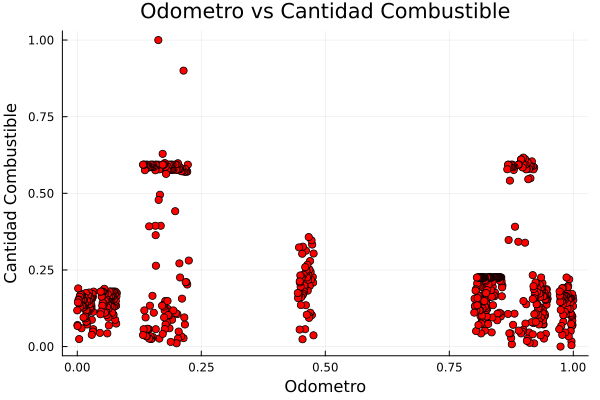

In [113]:
scatter(df.Odometro_Norm, df.Cantidad_Norm, title="Odometro vs Cantidad Combustible", xlabel="Odometro", ylabel="Cantidad Combustible", legend=false, color="red")

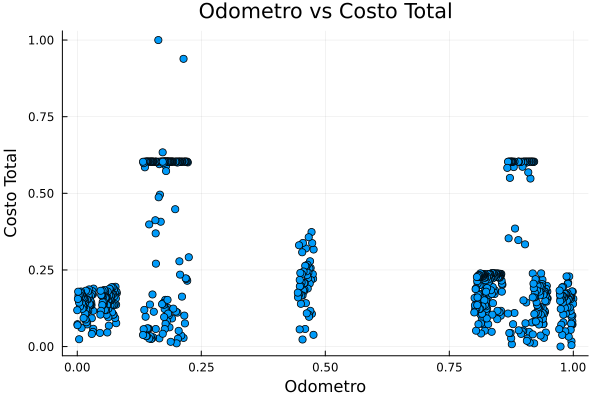

In [114]:
scatter(df.Odometro_Norm, df.Costo_Total_Norm, title="Odometro vs Costo Total", xlabel="Odometro", ylabel="Costo Total", legend=false)

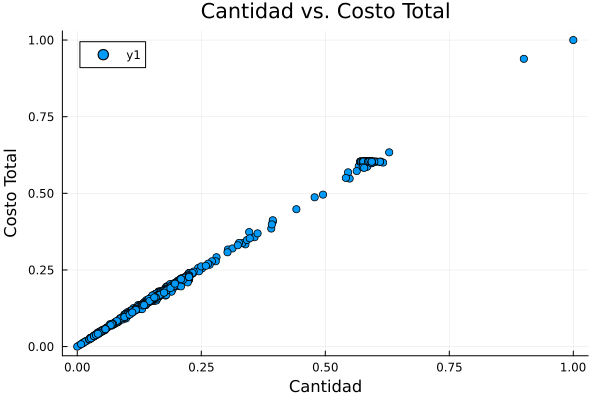

In [115]:
scatter(df.Cantidad_Norm, df.Costo_Total_Norm, title="Cantidad vs. Costo Total", xlabel="Cantidad", ylabel="Costo Total")

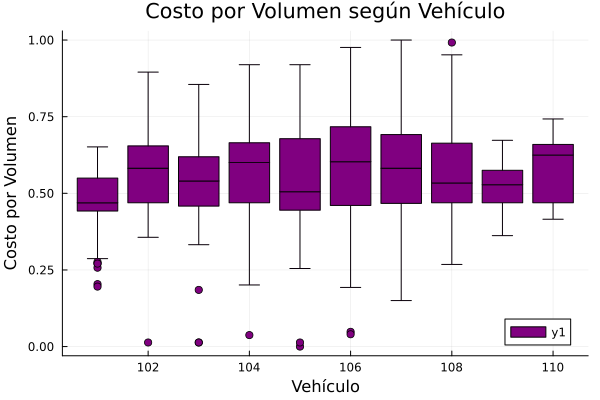

In [116]:
boxplot(df.Vehiculo, df.Costo_Por_Volumen_Norm, title="Costo por Volumen según Vehículo", xlabel="Vehículo", ylabel="Costo por Volumen", color="purple")

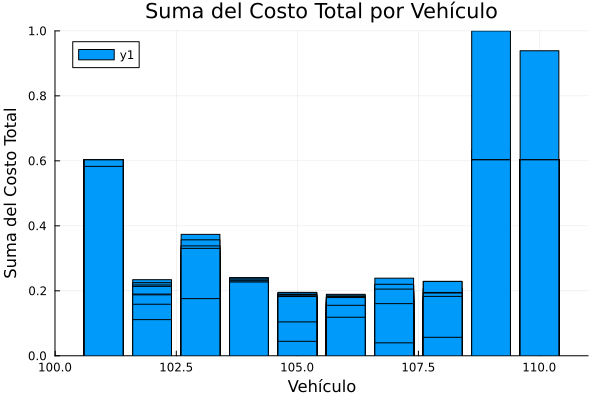

In [117]:
bar(df.Vehiculo, df.Costo_Total_Norm, title="Suma del Costo Total por Vehículo", xlabel="Vehículo", ylabel="Suma del Costo Total")

In [118]:
#pairplot(df, fullgrid=true)

# Función de regresión lineal
Predeciremos la cantidad usando el 

Odometro

Tanque_Lleno

Costo_Total

## Hipótesis

In [140]:
# hyp
# Odometro_Norm Float
# Tanque_Lleno_Norm Bool
# Costo_Total_Norm Float
hyp_df = select(df, [:Odometro_Norm, :Tanque_Lleno, :Costo_Total_Norm])
y = select(df, :Cantidad_Norm)

theta = [float(rand(-1:1)), float(rand(-1:1)), float(rand(-1:1))]
bias = 0.0

function hyp(bias::Vector{Float64}, theta::Vector{Float64}, df::DataFrame)
    results = Vector{Float64}(undef, nrow(df))
    for i in 1:nrow(df)
        results[i] = bias[i] + sum(theta[j] * df[i, j] for j in 1:length(theta))
    end
    return results
end

hyp(bias, theta, hyp_df)

MethodError: MethodError: no method matching hyp(::Float64, ::Vector{Float64}, ::DataFrame)

Closest candidates are:
  hyp(!Matched::Vector{Float64}, ::Vector{Float64}, ::DataFrame)
   @ Main ~/julia_MachineLearning/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X35sdnNjb2RlLXJlbW90ZQ==.jl:11


## Separating Data - Train - Test

In [106]:
# 90% for training
train_ratio = 0.9

# Calcular el número de muestras para el conjunto de entrenamiento
n_train = floor(Int, train_ratio * nrow(shuffled_df))

# Separar los índices en entrenamiento y prueba
train_df = shuffled_df[1:n_train, :]
test_df = shuffled_df[(n_train+1):end, :]

Row,Vehiculo,Odometro,Tanque_Lleno,Costo_Por_Volumen,Cantidad,Costo_Total
,Int64,Int64,Bool,Float32,Float32,Float32
1,105,486151,true,24.94,85.0,2120.0
2,108,1140917,true,25.73,125.0,3216.0
3,109,565575,true,25.19,397.0,9999.0
4,103,758225,true,25.99,125.51,3262.0
5,104,1024508,true,25.69,160.0,4110.0
6,109,559199,true,25.57,391.0,9999.0
7,106,441941,true,25.62,125.24,3208.73
8,109,530263,true,24.98,37.54,937.75
9,106,443550,true,25.09,121.0,3036.0


In [107]:
size(train_df)

(568, 6)

In [108]:
size(test_df)

(64, 6)

In [109]:
describe(df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Abstract…,Real,Float64,Real,Int64,DataType
1,Vehiculo,105.566,101,105.0,110,0,Int64
2,Odometro,8.12749e5,436624,1.0034e6,1142707,0,Int64
3,Tanque_Lleno,0.800633,false,1.0,true,0,Bool
4,Costo_Por_Volumen,25.2959,23.24,25.29,26.97,0,Float32
5,Cantidad,160.645,13.0,120.025,665.0,0,Float32
6,Costo_Total,4058.61,329.0,3055.5,16353.0,0,Float32
7,Odometro_Norm,0.532693,0.0,0.802711,1.0,0,Float64
8,Costo_Por_Volumen_Norm,0.551172,0.0,0.549598,1.0,0,Float32
9,Cantidad_Norm,0.226449,0.0,0.164149,1.0,0,Float32
